<a href="https://colab.research.google.com/github/hyeonsang010716/huggingface-study/blob/main/4_huggingface_image_matching.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 유사한 이미지 찾기 구현

In [ ]:
!pip install datasets==2.20.0

ViT 모델을 활용해서 이미지 특징 벡터 추출

In [ ]:
import torch
from datasets import load_dataset
from transformers import ViTImageProcessor, ViTModel

dataset = load_dataset("huggingface/cats-image")
image = dataset["test"]["image"][0]

model_name = "google/vit-base-patch16-224"
processor = ViTImageProcessor.from_pretrained(model_name)
model = ViTModel.from_pretrained(model_name)

inputs = processor(image, return_tensors="pt")
with torch.no_grad():
    outputs = model(inputs["pixel_values"])

print("마지막 특징 맵의 형태 :", outputs["last_hidden_state"].shape)
print("특징 벡터의 차원 수 :", outputs["last_hidden_state"][:, 0, :].shape)
print("특징 벡터 :", outputs["last_hidden_state"][:, 0, :])

CLIP 모델을 활용한 이미지 특징 벡터 추출

In [4]:
import torch
import numpy as np
from datasets import load_dataset
from transformers import CLIPProcessor, CLIPModel

dataset = load_dataset("sasha/dog-food")
images = dataset["test"]["image"][:100]

model_name = "openai/clip-vit-base-patch32"
processor = CLIPProcessor.from_pretrained(model_name)
model = CLIPModel.from_pretrained(model_name)

vectors = []
with torch.no_grad():
    for image in images:
        inputs = processor(images=image, padding=True, return_tensors="pt")
        outputs = model.get_image_features(**inputs)
        vectors.append(outputs.cpu().numpy())

vectors = np.vstack(vectors)
print("이미지 벡터의 shape :", vectors.shape)

Generating train split:   0%|          | 0/2100 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/900 [00:00<?, ? examples/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

이미지 벡터의 shape : (100, 512)


특징 벡터를 FAISS DB에 저장

In [ ]:
!pip install faiss-gpu

In [9]:
import faiss

dimension = vectors.shape[-1]
index = faiss.IndexFlatL2(dimension)
if torch.cuda.is_available():
    res = faiss.StandardGpuResources()
    index = faiss.index_cpu_to_gpu(res, 0, index)

index.add(vectors)

FAISS DB에서 유사도 검색을 통해 이미지 찾기

유사한 벡터의 인덱스 번호: [[ 0  6 75  1 73]]
유사도 계산 결과: [[ 0.       43.92244  44.924698 46.54413  47.058556]]


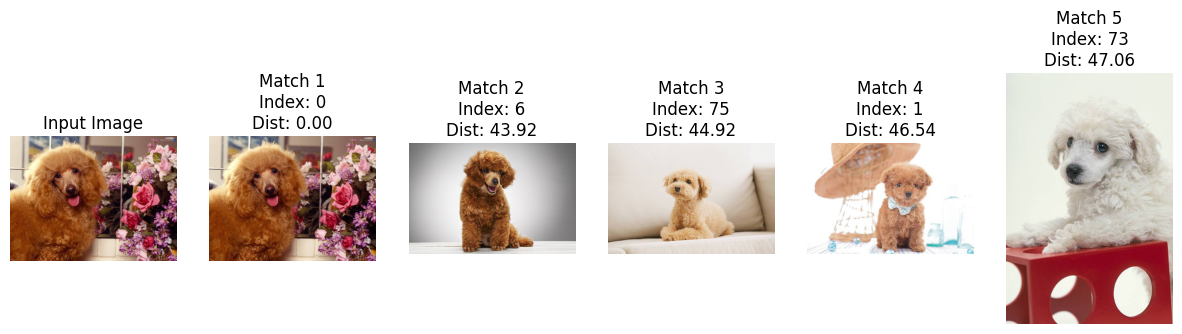

In [10]:
import matplotlib.pyplot as plt

search_vector = vectors[0].reshape(1, -1)
num_neighbors = 5
distances, indices = index.search(x=search_vector, k=num_neighbors)

fig, axes = plt.subplots(1, num_neighbors + 1, figsize=(15, 5))

axes[0].imshow(images[0])
axes[0].set_title("Input Image")
axes[0].axis("off")

for i, idx in enumerate(indices[0]):
    axes[i + 1].imshow(images[idx])
    axes[i + 1].set_title(f"Match {i + 1}\nIndex: {idx}\nDist: {distances[0][i]:.2f}")
    axes[i + 1].axis("off")

print("유사한 벡터의 인덱스 번호:", indices)
print("유사도 계산 결과:", distances)